In [1]:
import cobra as cb
import pandas as pd
import numpy as np
from cobra.util.solver import linear_reaction_coefficients



In [2]:
GROWTH_MIN_OBJ = 0.01

# Functions for breaking down iiFBA tasks

## Environment


In [ ]:
def init_iifba(models, media, iterations, m_vals=[1,1]):
	# get list of all unique rxns and exchanges
	org_exs = set()
	org_rxns = set()
	for model in models:
		exs_set = set(model.exchanges.list_attr("id"))
		org_exs = org_exs | exs_set # exchanges
		rxns_set = set(model.reactions.list_attr("id"))
		org_rxns = org_rxns | rxns_set # reactions

	# initialize env
	rows = (iterations) * m_vals[0] * m_vals[1] + 1 # add one iteration for final env
	cols = len(org_exs)
	env_f = np.zeros((rows, cols))
	env0_masks = [np.array(list(org_exs)) == rxn_id for rxn_id in list(media.keys()) ]
	for flux_idx, flux in enumerate(list(media.values())):
		env_f[0][env0_masks[flux_idx]] = flux
	
	#set columns for multi-indexing
	iters_col = np.repeat(np.arange(1, iterations+1), m_vals[0] * m_vals[1]) 
	run_col = np.tile(np.arange(m_vals[0] * m_vals[1]), iterations)
	iters_col = np.insert(iters_col, 0, 0) # add 0th iteration
	run_col = np.insert(run_col, 0, 0) # add 0th run 
	multi_idx = [iters_col , run_col]
	env_f = pd.DataFrame(env_f, columns=list(org_exs), index=multi_idx) # convert to interprettable df
	env_f.index.names = ["Iteration", "Run"]

	# initialize org_fluxes
	rows = iterations * m_vals[0] * m_vals[1] * len(models)
	cols = len(org_rxns)
	org_F = np.zeros((rows, cols)) # pfba will drop run column
	
	# create unique multi-index for 
	models_col = np.tile(np.arange(len(models)), iterations * m_vals[0] * m_vals[1]) 
	iters_col = np.repeat(np.arange(iterations), m_vals[0] * m_vals[1] * len(models)) 
	run_col = np.tile(np.repeat(np.arange(m_vals[0] * m_vals[1]), len(models)), iterations) 
	multi_idx = [models_col, iters_col , run_col]
	org_F = pd.DataFrame(org_F, columns=list(org_rxns), index=multi_idx)	# convert to interprettable df
	org_F.index.names = ["model", "Iteration", "Run"]
	
	return env_f, org_F

In [ ]:
def set_env(model, env_f, iter, run):
	for ex in model.exchanges:
		ex.lower_bound = env_f.loc[iter, run][ex.id]
	
	return model

## Optimization

In [ ]:
def run_pfba(model, model_idx, iter, org_F):
	# run pFBA
	sol1 = model.slim_optimize()
	if sol1 > GROWTH_MIN_OBJ:
		sol = cb.flux_analysis.parsimonious.pfba(model)
		
		org_F.loc[(model_idx, iter, 0), list(sol.fluxes.index)] = sol.fluxes.values
	# do nothing otherwise - already initiated as zeros!

	return org_F

In [ ]:
def run_sampling(model, model_idx, iter, org_F, m_vals, rep_idx, obj_percent):
	# ensure sample space is constrained above a certain objective value
	min_obj = model.slim_optimize() * obj_percent
	
	# set obj to be above min_obj
	obj_rxn = [rxn.id for rxn in linear_reaction_coefficients(model).keys()][0]
	model.reactions.get_by_id(obj_rxn).lower_bound = min_obj

	# run flux sampling
	if iter == 0:
		sample_ct = m_vals[0] * m_vals[1]
	else:
		sample_ct = m_vals[1]
	sol = cb.sampling.sample(model, sample_ct)
	
	# standardize and save output
	arrays = [[model_idx] * sample_ct, [iter] * sample_ct, list(sol.index + rep_idx * sample_ct)]
	tuples = list(zip(*arrays))
	multi_idx = pd.MultiIndex.from_tuples(tuples, names=['model', 'Iteration', 'Run'])
	sol.index = multi_idx
	
	org_F.loc[sol.index, sol.columns] = sol

	return org_F

	


## Flux Update

In [ ]:
def update_pfba_env(env_f, org_F, flow, rel_abund, iter):
	# get initial env. for flow
	init_env = env_f.loc[0,0].to_numpy()
	#pull iter info
	env_tmp = env_f.loc[iter, 0][:].to_numpy()
	run_exs = org_F.loc[:, iter, 0][env_f.columns].to_numpy()
		
	# run update
	flux_sums = (run_exs.T @ rel_abund).flatten()
	env_f.loc[iter+1, 0] = (1-flow)*(env_tmp - flux_sums) + flow*init_env
	
	return env_f


In [ ]:
def update_sampling_env(env_f, org_F, flow, rel_abund, iter, m_vals, Mi, rep_idx):
	# get initial env. for flow
	init_env = env_f.loc[(0,0)].to_numpy()

	sample_ct = m_vals[0] * m_vals[1] if iter == 0 else m_vals[1]
	for sample_idx in range(sample_ct):
		#pull run info
		env_tmp = env_f.loc[iter, Mi][:].to_numpy()
		run_exs = org_F.loc[:, iter, Mi][env_f.columns].to_numpy()

		# run update
		flux_sums = (run_exs.T @ rel_abund).flatten()
		env_f.loc[iter+1, sample_idx+ m_vals[1]*rep_idx] = (1-flow)*(env_tmp - flux_sums) + flow*init_env

	return env_f

## Wrapper Function


In [ ]:
def iipfba(models, media, rel_abund=None,
		   iters=10, flow=0.5):
	models, media, iters, flow, rel_abund, _, _ = input_validation(models, media, iters, flow, rel_abund)

	env_fluxes, org_fluxes = init_iifba(models, media, iters)

	for iter in range(iters):
		print("Iteration:", iter)

		for org_idx, org_model in enumerate(models):
			with org_model as model:
				# set exchanges
				model = set_env(model, env_fluxes, iter, 0) # only 0 runs

				# run optim
				org_fluxes = run_pfba(model, org_idx, iter, org_fluxes)
				
		# update fluxes
		env_fluxes = update_pfba_env(env_fluxes, org_fluxes, flow, rel_abund, iter)

	# pfba has no use for Run index
	env_fluxes = env_fluxes.droplevel("Run")
	org_fluxes =org_fluxes.droplevel("Run")

	return env_fluxes, org_fluxes

In [ ]:
def iisampling(models, media, rel_abund, iters=10, flow=0.5, m_vals=[1,1], objective_percent= 0.9):
	models, media, iters, flow, rel_abund, m_vals, objective_percent = input_validation(models, media, iters, flow, rel_abund, m_vals, objective_percent)

	# mapping of what flux sampling to iterate
	M = np.zeros([m_vals[0],iters],dtype=int) #randomly pre-assign sampling initial point matrix
	for i in range(1, iters):
		Mcol = np.sort(np.random.choice(m_vals[0]*m_vals[1],m_vals[0],replace=False))
		M[:,i]=Mcol

	# initialize env and org fluxes
	env_fluxes, org_fluxes = init_iifba(models, media, iters, m_vals)

	for iter in range(iters):
		print("Iteration:", iter)

		# number of times to re-sample per iteration
		repeat_ct = 1 if iter == 0 else m_vals[0] 
		for rep_idx in range(repeat_ct):
			Mi = M[rep_idx, iter]

			# samples taken
			samples = m_vals[0] * m_vals[1] if iter == 0 else m_vals[1]
			for org_idx, org_model in enumerate(models):
				with org_model as model:
					# set exchanges
					model = set_env(model, env_fluxes, iter, Mi)

					# run optim
					org_fluxes = run_sampling(model, org_idx, iter, org_fluxes, m_vals, rep_idx=rep_idx, obj_percent=objective_percent)
				
		# update fluxes
		env_fluxes = update_sampling_env(env_fluxes, org_fluxes, flow, rel_abund, iter, m_vals, Mi, rep_idx)


	return env_fluxes, org_fluxes, M

In [ ]:
def input_validation(models=None, media=None, iters=None, flow=None, 
					 rel_abund="None", m_vals=None, obj_percent=None):
	if models is not None or not isinstance(models, list):
		raise ValueError("models must be a list of cobra.Model objects.")
	
	if media is not None or not isinstance(media, dict):
		raise ValueError("media must be a dictionary with reaction IDs as keys and flux values as values.")
	
	if iters is not None:
		if not isinstance(iters, int):
			iters = int(iters)
		if iters < 1:
			iters = 1
		print("Iterations set to:", iters)
	
	if flow is not None:
		if not isinstance(flow, float):
			flow = float(flow)
		if flow < 0 or flow > 1:
			flow = 0.5
		print("Flow set to:", flow)
	
	if rel_abund != "None":
		if not isinstance(rel_abund, np.ndarray):
			rel_abund = np.array(rel_abund)
		if rel_abund.ndim != 1:
			raise ValueError("Relative abundances must be a 1D array.")
		if np.any(rel_abund < 0) or np.sum(rel_abund) == 0:
			raise ValueError("Relative abundances must be non-negative and sum to a positive value.")
		if rel_abund.sum() != 1:
			rel_abund = rel_abund / rel_abund.sum()
		if rel_abund is None:
			rel_abund = np.ones(len(models)) / len(models)
		print("Relative abundances set to:", rel_abund)

	if m_vals is not None:
		if not isinstance(m_vals, np.ndarray) or len(m_vals) != 2:
			raise ValueError("m_vals must be a list of two integers.")
		if sum(m_vals > 0) != 2:
			m_vals[m_vals <=0] = 1
		m_vals = np.array(m_vals, dtype=int)
		print("m_vals set to:", m_vals)
	
	if obj_percent is not None:
		if not isinstance(obj_percent, float):
			obj_percent = float(obj_percent)
		if obj_percent < 0 or obj_percent > 1:
			obj_percent = 0.9
		print("Objective percent set to:", obj_percent)
		
	return models, media, iters, flow, rel_abund, m_vals, obj_percent


# Test Models

In [ ]:
# model_pre_processing
mod_paths = ['../AGORA2_Models/Escherichia_coli_str_K_12_substr_MG1655.mat',
			 "../AGORA2_Models/Bacteroides_thetaiotaomicron_3731.mat"]
S_matrix = [] #list of models
# Load Models and Save in S vector
for i in range(len(mod_paths)):
	model = cb.io.load_matlab_model(mod_paths[i])
	S_matrix.append(model) #append models to list

# Define input environment f_0
# this should be defined as a pandas dataframe with columns "Reaction" and "LB"
# glucose minimal medium
# Define Medium Components
glc_min_med = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_no3(e)','EX_pi(e)','EX_cys_L(e)',
			   'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)','EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
glc_min_med_flux = [-10,-100,-100,-100,-100,-100,
					-100,-100,-100,-100,-100,-100,-100,-100,-100,-100]

glc_f0 = pd.DataFrame(data={'Reaction': glc_min_med,'LB': glc_min_med_flux})
glc_f0 = dict(zip(glc_min_med, glc_min_med_flux))
print(glc_f0)

FileNotFoundError: [Errno 2] No such file or directory: '../AGORA2_Models/Escherichia_coli_str_K_12_substr_MG1655.mat'

In [ ]:
f, F = iipfba(S_matrix, glc_f0, np.array([0.5, 0.5]).reshape((-1,1)))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [ ]:
f, F, M = iisampling(S_matrix, glc_f0, np.array([0.5, 0.5]).reshape((-1,1)), 
				  iters=10, m_vals=[10,10])

# print((f.loc[0,:].to_numpy()).sum(axis=1))
# print(f)
# print(F)

import pickle
with open('ii_sampling_061025.pkl', 'wb') as file:
	pickle.dump([f, F, M], file)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [ ]:
F.loc[0 ,: ,:][["biomass525"]]


biomass525
Iteration Run            
0         0      0.706174
          1      0.706173
          2      0.706651
          3      0.706407
          4      0.706174
...                   ...
9         95     0.419227
          96     0.419252
          97     0.419253
          98     0.419291
          99     0.419279

[1000 rows x 1 columns]

In [ ]:
print(F.loc[0, :]["biomass525"])

Iteration
0    0.784637
1    0.505684
2    0.472349
3    0.465576
4    0.464291
5    0.463970
6    0.463890
7    0.463870
8    0.463865
9    0.463863
Name: biomass525, dtype: float64


In [4]:
import pickle
with open('ii_sampling_070725_0.4.pkl', 'rb') as file:
	f, F, M = pickle.load(file)

In [19]:
x = F.loc[1, :, :]["EX_ac(e)"]
x

Iteration  Run
0          0      6.194395e-01
           1      5.472009e-01
           2      6.911075e-01
           3      7.458723e-01
           4      7.321392e-01
                      ...     
9          95    -6.104351e-12
           96     3.715379e-12
           97    -1.425651e-12
           98     7.736041e-12
           99    -5.419635e-13
Name: EX_ac(e), Length: 1000, dtype: float64

(100, 10)

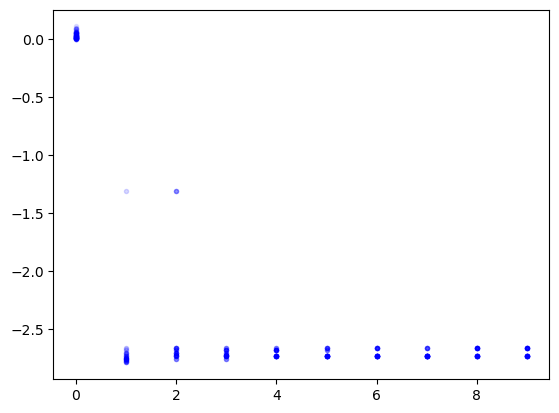

In [5]:
flux = "EX_ac(e)"
# flux = 'EX_glc_D(e)'
# flux = 'biomass525'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot Sampling Results
# Sort the MultiIndex DataFrame
F = F.sort_index()
org = 0
cum_sum = np.zeros(M.shape[0] * M.shape[1])
for iteration in F.index.get_level_values('Iteration').unique().to_list():
	iter_arr = np.full(M.shape[0]*M.shape[1], iteration)
	
	sample_ct = M.shape[0] * M.shape[1] if iteration == 0 else M.shape[1]
	
	cum_sum = np.zeros(sample_ct)
# iter 0: runs 0-99  all M=0
# iter 1: runs 0:9   M[0, 1], iter0, run # M[0,1] + iter 1: runs 0:9
# iter 1: runs 10:19  M[1, 1]	
# iter 1: runs 20:29  M[2, 1]

# iter 2: runs 0:9   M[0, 2]
# iter 2: runs 10:19  M[1, 2]	
# iter 2: runs 20:29  M[2, 2]



import matplotlib.pyplot as plt

# Plot Sampling Results
org = 0
flux = 'EX_ac(e)'
#flux = 'EX_glc_D(e)'
#flux = 'biomass525'

iter_sums = np.zeros((100, 10))
# First iteration
iter=0
plt.plot(np.full(F.loc[org, iter, :][flux].shape, iter),F.loc[org, iter, :][flux],'b.',alpha=0.1)
iter_sums[:, 0] = F.loc[org, iter, :][flux]

# second iteration
for iter in range(1, M.shape[1]):
	for run_subset_idx in range(M.shape[0]):
		m_ind = M[run_subset_idx, iter]
		run_subset = range(run_subset_idx*M.shape[0], (run_subset_idx+1)*M.shape[0])
		iter_sums[run_subset, iter] = iter_sums[m_ind, iter-1] + F.loc[org, iter, :][flux].to_numpy()[run_subset]
		plt.plot(np.full(iter_sums[run_subset, iter].shape, iter), iter_sums[run_subset, iter],'b.',alpha=0.05)
		



org = 0
flux = 'EX_ac(e)'
# flux = 'EX_glc_D(e)'
# flux = 'bio1'

# # First iteration
# for j in range(len(F.loc[org, 0, :][flux])):
#     plt.plot(0,F.loc[org, 0, j][flux],'r.',alpha=0.1)

# # N+1 iterations
# for i in range(1, M.shape[1]):
#     #dots for all flux values
#     for j in range(len(F.loc[org, i, :][flux])):
#         plt.plot(i,F.loc[org, i, j][flux],'r.',alpha=0.1)
#     # #lines linking flux values
#     # for j in range(len(F.loc[org, i, :][flux])):
#     #     m_ind = M[int(j/M.shape[0])][i-1]
#     #     plt.plot([i-1,i],[F.loc[org, i-1, m_ind][flux],F.loc[org, i, j][flux]],'r-',alpha=0.05)  
# 

iter_sums.shape
	

In [ ]:
M


array([[ 0, 10,  0,  8,  9,  0,  6,  2,  1,  2],
       [ 0, 15,  1,  9, 20,  9,  9,  8,  6, 19],
       [ 0, 29,  3, 12, 33, 11, 12, 20,  8, 25],
       [ 0, 38,  4, 14, 39, 17, 13, 21, 22, 26],
       [ 0, 62,  8, 22, 46, 19, 18, 71, 32, 33],
       [ 0, 73, 29, 39, 69, 27, 46, 79, 34, 38],
       [ 0, 77, 57, 58, 71, 31, 53, 81, 36, 84],
       [ 0, 84, 61, 63, 72, 36, 56, 88, 66, 85],
       [ 0, 88, 63, 79, 76, 42, 84, 89, 72, 90],
       [ 0, 91, 79, 96, 78, 69, 86, 99, 92, 92]])

In [1]:
import cobra as cb
import pandas as pd
import numpy as np
from cobra.util.solver import linear_reaction_coefficients



In [2]:
# model_pre_processing
mod_paths = ['../Examples/AGORA2_Models/Escherichia_coli_str_K_12_substr_MG1655.mat',
			 "../Examples/AGORA2_Models/Bacteroides_thetaiotaomicron_3731.mat"]
S_matrix = [] #list of models
# Load Models and Save in S vector
for i in range(len(mod_paths)):
	model = cb.io.load_matlab_model(mod_paths[i])
	S_matrix.append(model) #append models to list

# Define input environment f_0
# this should be defined as a pandas dataframe with columns "Reaction" and "LB"
# glucose minimal medium
# Define Medium Components
glc_min_med = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_no3(e)','EX_pi(e)','EX_cys_L(e)',
			   'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)','EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
glc_min_med_flux = [-10,-100,-100,-100,-100,-100,
					-100,-100,-100,-100,-100,-100,-100,-100,-100,-100]

glc_f0 = pd.DataFrame(data={'Reaction': glc_min_med,'LB': glc_min_med_flux})
glc_f0 = dict(zip(glc_min_med, glc_min_med_flux))
print(glc_f0)

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


{'EX_glc_D(e)': -10, 'EX_so4(e)': -100, 'EX_nh4(e)': -100, 'EX_no3(e)': -100, 'EX_pi(e)': -100, 'EX_cys_L(e)': -100, 'EX_mn2(e)': -100, 'EX_cl(e)': -100, 'EX_ca2(e)': -100, 'EX_mg2(e)': -100, 'EX_cu2(e)': -100, 'EX_cobalt2(e)': -100, 'EX_fe2(e)': -100, 'EX_fe3(e)': -100, 'EX_zn2(e)': -100, 'EX_k(e)': -100}


In [3]:
import iifba
import cobra
import pickle

for x in range(3):
	percent = (x+1) /5
	
	f, F, M = iifba.iisampling(S_matrix, glc_f0, rel_abund="Equal", m_vals=[10,10], objective_percent=percent)

	with open(f'ii_sampling_070725_{percent}.pkl', 'wb') as file:
		pickle.dump([f, F, M], file)

Iterations set to: 10
Relative abundances set to: [0.5 0.5]
m_vals set to: [10 10]
Objective percent set to: 0.2
Iteration: 0
Read LP format model from file /tmp/tmppxtehjs2.lp
Reading time = 0.01 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
Read LP format model from file /tmp/tmpv1eb3ixd.lp
Reading time = 0.00 seconds
: 1318 rows, 3010 columns, 11452 nonzeros
Iteration: 1
Read LP format model from file /tmp/tmp6s8cyhse.lp
Reading time = 0.01 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
Read LP format model from file /tmp/tmpawwp2__k.lp
Reading time = 0.00 seconds
: 1318 rows, 3010 columns, 11452 nonzeros
Read LP format model from file /tmp/tmp91jc7guz.lp
Reading time = 0.01 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
Read LP format model from file /tmp/tmp5dmj_87u.lp
Reading time = 0.00 seconds
: 1318 rows, 3010 columns, 11452 nonzeros
Read LP format model from file /tmp/tmp6lc16oe8.lp
Reading time = 0.01 seconds
: 2630 rows, 6554 columns, 22274 nonzeros
Read LP format

AttributeError: Element 0 of a double array is Nan.